# QMPI - point to point methods

myenv kernel with python 3.10

In [2]:
# imports and initialization
import matplotlib.pyplot as plt
import qiskit
import numpy as np

from azure.quantum.qiskit import AzureQuantumProvider

#paste your Resource id here
resource_id = "/subscriptions/4808ed5e-3bea-4247-b6f0-6eb7b1eedc01/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/PHY-576-Quantum-Implementations-Tommy-Nguyen"

#Import your azure quantum provider resource_id
provider = AzureQuantumProvider (
    resource_id = resource_id,
    location = "westus"
)

from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

# Import qiskit packages for learning purposes
from qiskit import QuantumCircuit, assemble, Aer, transpile, execute, QuantumRegister, ClassicalRegister

# Import quantum simulators
from qiskit.providers.jobstatus import JobStatus
aer_sim = Aer.get_backend('aer_simulator')
ionq_sim = provider.get_backend("ionq.simulator")

In [2]:
# My communicator will be an overall quantumcircuit and everything will be done with quantum registers
QMPI_COMM_WORLD = QuantumCircuit()

In [3]:
# Allocates n qubits in a quantum register data type
def QMPI_Alloc_qmem(n):
    return QuantumRegister(n)

# can't do QMPI_Free_qmem 

# this might be given to me later but I need to make an auxillary function for this so I can test out my methods
# qubit1 and qubit2 are the 2 qubits to make the EPR pair with. Tag is the message tag. Assume that both are |0>. 
# comm is the quantum circuit. NOT SURE WHAT TO DO WITH TAG
def QMPI_Prepare_EPR(qubit1, qubit2, tag, comm):
    comm.h(qubit1)
    comm.cx(qubit1, qubit2)

# data is the qubit we are trying to send. epr1 and epr2 are the |0> qubit epr pairs that haven't been entangled yet so epr2 is the qubit
# that the data is sent to. 
def QMPI_Send_move(data, epr1, epr2, tag, comm):
    comm.barrier()
    QMPI_Prepare_EPR(epr1, epr2, tag, comm)
    comm.barrier()
    comm.cx(data, epr1)

    cr1 = ClassicalRegister(2)
    comm.add_register(cr1)

    comm.measure(epr1, cr1[0])
    comm.x(epr2).c_if(cr1[0],1)
    comm.barrier()

    comm.h(data)
    comm.measure(data, cr1[1])
    comm.reset(data)
    comm.z(epr2).c_if(cr1[1],1)

# data is the qubit to recieve the data from and this just measures that qubit
def QMPI_Recv_move(data, tag, comm):
    cr1 = ClassicalRegister(1)
    comm.add_register(cr1)
    comm.measure(data, cr1)

# grover's algorithm for 2 qubits
def grover(qubit1, qubit2, tag, comm):
    QMPI_Prepare_EPR(qubit1, qubit2, tag, comm)
    comm.barrier()
    comm.h(qubit1)
    comm.x(qubit2)
    comm.h(qubit2)
    comm.x(qubit1)

    # have to cnot the 2 qubits here. To do this, I'll make use of another entangled pair but if have cnot functionality then can do this
    # depends on how entanglement is genrated. Can I trust this?
    comm.barrier()
    comm.cx(qubit1, qubit2)
    comm.barrier()

    comm.h(qubit2)
    comm.x(qubit1)
    comm.h(qubit1)
    comm.x(qubit2)
    comm.h(qubit2)

    cr1 = ClassicalRegister(2)
    comm.add_register(cr1)
    comm.measure(qubit1, cr1[0])
    comm.measure(qubit2, cr1[1])





[QuantumRegister(2, 'qc1'), QuantumRegister(1, 'qc2')]


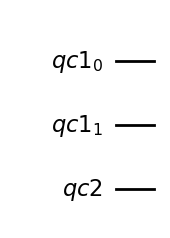

In [4]:
QMPI_COMM_WORLD = QuantumCircuit()
qr1 = QuantumRegister(2, name = "qc1")
qr2 = QuantumRegister(1, name = "qc2")
QMPI_COMM_WORLD.add_register(qr1, qr2)
print(QMPI_COMM_WORLD.qregs)
QMPI_COMM_WORLD.draw('mpl')

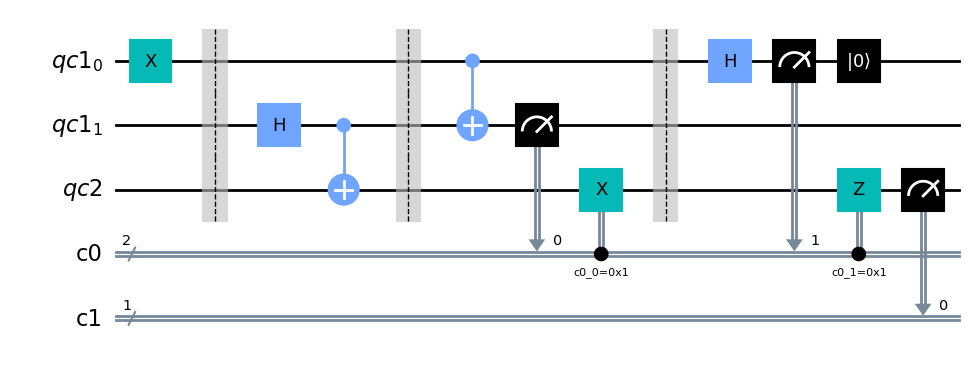

In [5]:
QMPI_COMM_WORLD.x(qr1[0])
QMPI_Send_move(qr1[0], qr1[1], qr2[0], _, QMPI_COMM_WORLD)
QMPI_Recv_move(qr2[0], _, QMPI_COMM_WORLD)
QMPI_COMM_WORLD.draw('mpl')

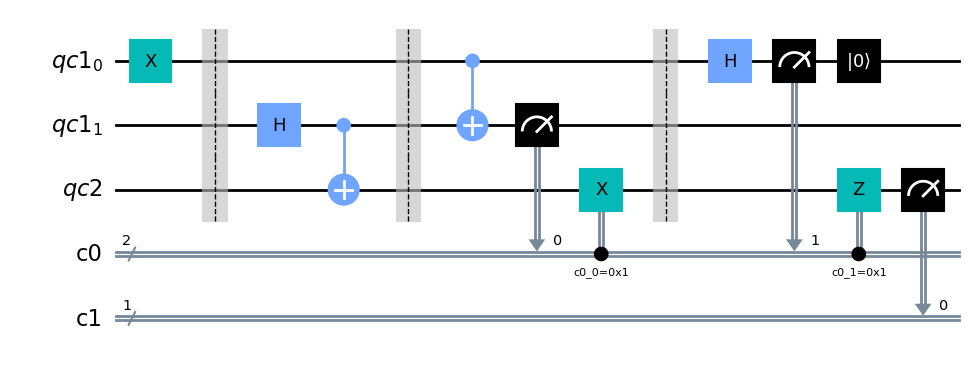

In [6]:
circ = transpile(QMPI_COMM_WORLD, aer_sim)
circ.draw('mpl')

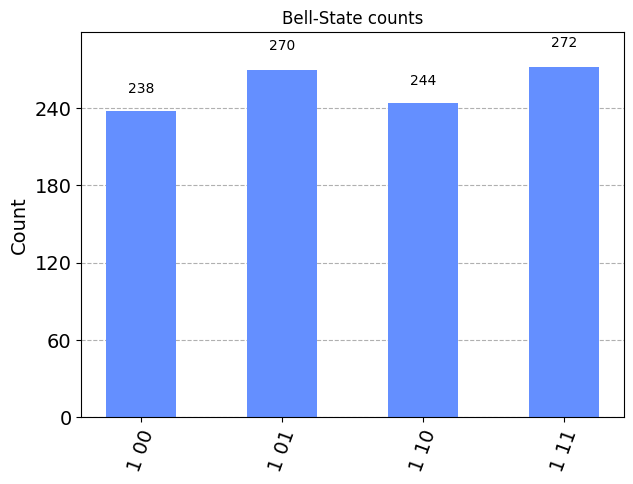

In [7]:
result = aer_sim.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

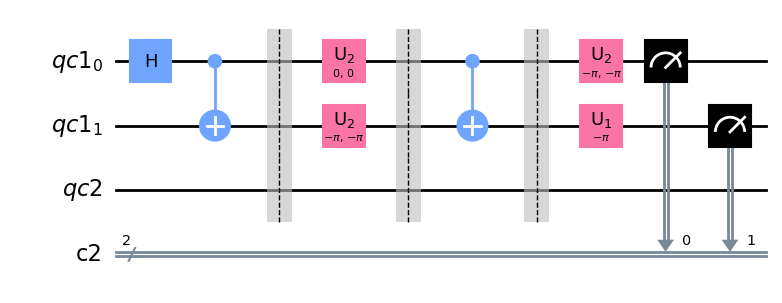

In [8]:
QMPI_COMM_WORLD = QuantumCircuit()
qr1 = QuantumRegister(2, name = "qc1")
qr2 = QuantumRegister(1, name = "qc2")
QMPI_COMM_WORLD.add_register(qr1, qr2)
grover(qr1[0], qr1[1], _ , QMPI_COMM_WORLD)
circ = transpile(QMPI_COMM_WORLD, aer_sim)
circ.draw('mpl')

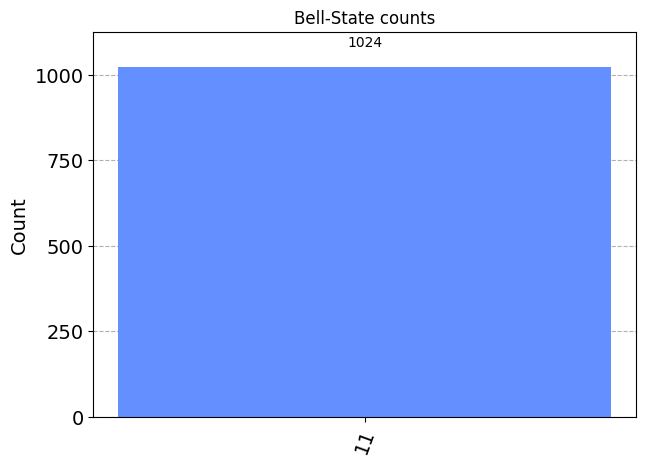

In [9]:
result = aer_sim.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

## Test Code

In [1]:
q = QuantumCircuit()
#q.reset(0)
qr1 = QuantumRegister(1, name = "qc1")
qr2 = QuantumRegister(1, name = "qc2")
cr1 = ClassicalRegister(2, name = "cr1")
q.add_register(qr1,qr2)
q.add_register(cr1)
q.x(qr1[0])
q.measure(qr1[0],cr1[0])
q.cx(qr1[0],qr2[0])
q.swap(qr1[0],qr2[0])
q.reset(qr1[0])
q.x(qr1[0])
q.measure(qr1[0],cr1[1])
q.draw('mpl')

NameError: name 'QuantumCircuit' is not defined

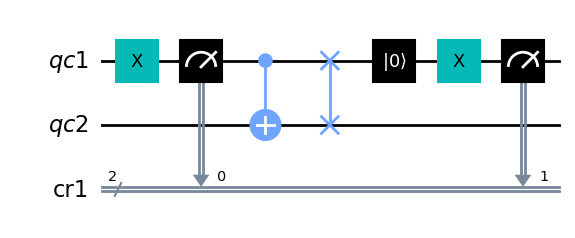

In [76]:
circ = transpile(q, aer_sim)
circ.draw('mpl')


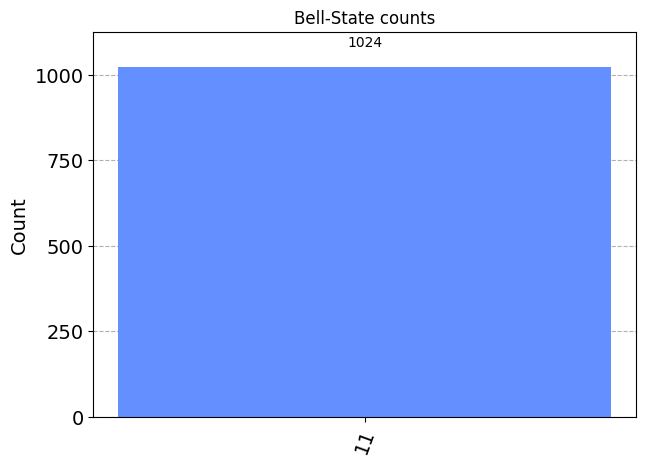

In [77]:
result = aer_sim.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

In [78]:
instruct = q.to_instruction()

In [79]:
instructions = []
gates = []
new_gates = []
for instruction, qargs, cargs in q:
    gates.append(instruction.name)    
    if instruction.name not in ['x', 'y', 'z', 'cx']:
        instruction = qiskit.circuit.library.XGate()    
    new_gates.append(instruction.name)
    instructions.append((instruction, qargs, cargs))

print(f"Gates in the original circuit: {gates}")
print(f"Gates in the new circuit: {new_gates}")
print(instructions)

Gates in the original circuit: ['x', 'measure', 'cx', 'swap', 'reset', 'x', 'measure']
Gates in the new circuit: ['x', 'x', 'cx', 'x', 'x', 'x', 'x']
[(Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(1, 'qc1'), 0)], []), (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(1, 'qc1'), 0)], [Clbit(ClassicalRegister(2, 'cr1'), 0)]), (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(1, 'qc1'), 0), Qubit(QuantumRegister(1, 'qc2'), 0)], []), (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(1, 'qc1'), 0), Qubit(QuantumRegister(1, 'qc2'), 0)], []), (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(1, 'qc1'), 0)], []), (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(1, 'qc1'), 0)], []), (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(1, 'qc1')

In [80]:
for i,j,k in q:
    print(i)
    print(j)
    print(k)

Instruction(name='x', num_qubits=1, num_clbits=0, params=[])
[Qubit(QuantumRegister(1, 'qc1'), 0)]
[]
Instruction(name='measure', num_qubits=1, num_clbits=1, params=[])
[Qubit(QuantumRegister(1, 'qc1'), 0)]
[Clbit(ClassicalRegister(2, 'cr1'), 0)]
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
[Qubit(QuantumRegister(1, 'qc1'), 0), Qubit(QuantumRegister(1, 'qc2'), 0)]
[]
Instruction(name='swap', num_qubits=2, num_clbits=0, params=[])
[Qubit(QuantumRegister(1, 'qc1'), 0), Qubit(QuantumRegister(1, 'qc2'), 0)]
[]
Instruction(name='reset', num_qubits=1, num_clbits=0, params=[])
[Qubit(QuantumRegister(1, 'qc1'), 0)]
[]
Instruction(name='x', num_qubits=1, num_clbits=0, params=[])
[Qubit(QuantumRegister(1, 'qc1'), 0)]
[]
Instruction(name='measure', num_qubits=1, num_clbits=1, params=[])
[Qubit(QuantumRegister(1, 'qc1'), 0)]
[Clbit(ClassicalRegister(2, 'cr1'), 1)]


In [81]:
tt = q.decompose()
for i, j, k in tt.data:
    print(i)
    print(j)
    print(k)

Instruction(name='u3', num_qubits=1, num_clbits=0, params=[3.141592653589793, 0, 3.141592653589793])
[Qubit(QuantumRegister(1, 'qc1'), 0)]
[]
Instruction(name='measure', num_qubits=1, num_clbits=1, params=[])
[Qubit(QuantumRegister(1, 'qc1'), 0)]
[Clbit(ClassicalRegister(2, 'cr1'), 0)]
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
[Qubit(QuantumRegister(1, 'qc1'), 0), Qubit(QuantumRegister(1, 'qc2'), 0)]
[]
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
[Qubit(QuantumRegister(1, 'qc1'), 0), Qubit(QuantumRegister(1, 'qc2'), 0)]
[]
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
[Qubit(QuantumRegister(1, 'qc2'), 0), Qubit(QuantumRegister(1, 'qc1'), 0)]
[]
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
[Qubit(QuantumRegister(1, 'qc1'), 0), Qubit(QuantumRegister(1, 'qc2'), 0)]
[]
Instruction(name='reset', num_qubits=1, num_clbits=0, params=[])
[Qubit(QuantumRegister(1, 'qc1'), 0)]
[]
Instruction(name='u3', num_qubits=1, num_clbits

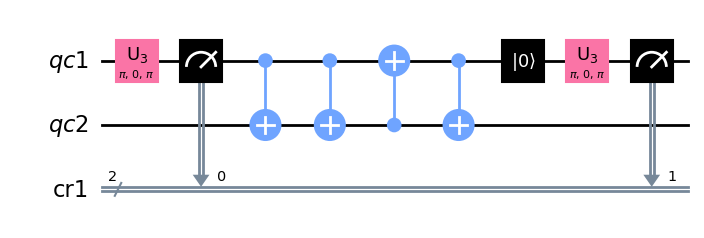

In [82]:
tt.draw('mpl')

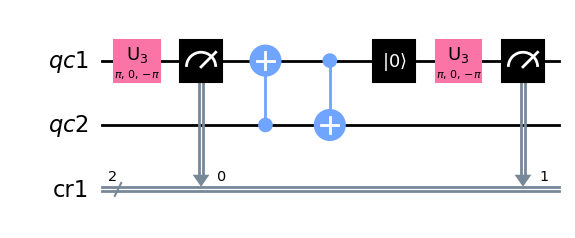

In [83]:
circ = transpile(tt, aer_sim)
circ.draw('mpl')